In [27]:
import networkx as nx 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import copy
from scipy.integrate import odeint
from scipy.optimize import root_scalar
import random 
from bisect import bisect_right 
import time
from mpmath import *
from mpl_toolkits import mplot3d
import pickle
import multiprocessing as mp

In [28]:
def divide_test(Q,P):
    
    mod = Q%P
    
    size = (int)(Q/P)
    
    chunks = []
    
    idx = 0
    
    for i in range(P):
        chunks.append([])
        for j in range(size):
            chunks[i].append(idx)
            idx=idx+1
        
        if i<mod:
            chunks[i].append(idx)
            idx=idx+1
            
    return chunks
    

In [128]:
def expandPool(test_subjects,N_nodes,PercentInc,Q=200):
    
    newpool = random.sample([n for n in N_nodes if n not in test_subjects],(int)(PercentInc*3800))
    test_subjects.extend(newpool)
    return test_subjects

In [182]:
def network_iter(G,percentInc,Q=200,P=7,N=4000,M=800,b=0.075,gamma=0.2): # N: total population, M: number of edge nodes
                                                             # P:testing period, Q: number of nodes being tested
    N_nodes = set(np.arange(0,N,1))             
     
    test_subjects = random.sample(N_nodes,Q)             # randomly sample Q testing subjects from whole population
    
    test_lists = divide_test(Q,P)
    
    edges = random.sample(N_nodes,M)                     # randomly sample M edges nodes (boundary conditions) from whole population
    
    infected= random.sample(set(edges),1)                # randomly select 1 node from M edge nodes to be first infected
    
    suscep=[s for s in N_nodes if s not in infected]     # rest are susceptible 
    
    removed=[]

    for inf in infected:                           #initialize node attribute
        G.nodes[inf]['status']='infected'
        G.nodes[inf]['inf_dur']= 0
        G.nodes[inf]['ID']= 'None'

    for sus in suscep:
        G.nodes[sus]['status']='susceptible'
        G.nodes[sus]['ID']= 'None'
        
    for t in test_subjects:
        G.nodes[t]['ID']= 'Tested'
        
            
    
    detected = False
    
    detection_day = -1
   
    gamma_inverse = 5
    I = 1
    S = N-I
    R = 0
    dt = 1
    
    counter= 0

    I_record=[1]
    S_record=[N-1]
    R_record=[0]
    TotalCases = I+R
    finished = False

    while len(infected)>0:

        addTestSubjects = False
        
        new_infected = []

        for sus in suscep:
            nei = G[sus].keys()       # get current susceptible's neighbors
            infected_nei = [n for n in nei if G.nodes[n]['status']=='infected']   # get infectious neighbors
            p_infection = 1-np.power((1-b*dt),len(infected_nei))
            inf_status = np.random.binomial(1,p_infection)
            if inf_status==1:
                new_infected.append(sus)
                I=I+1
                S=S-1

        new_removed = []

        for inf in infected:

            G.nodes[inf]['inf_dur']=G.nodes[inf]['inf_dur']+dt

            if G.nodes[inf]['inf_dur']>=gamma_inverse:
                new_removed.append(inf)
                I=I-1
                R=R+1


        new_infected= list(dict.fromkeys(new_infected))
        new_removed = list(dict.fromkeys(new_removed))

        for re in new_removed:
            infected.remove(re)
            G.nodes[re]['status']='removed'

        for inf in new_infected:
            suscep.remove(inf)
            G.nodes[inf]['status']='infected'
            G.nodes[inf]['inf_dur']=0

        infected.extend(new_infected)
        removed.extend(new_removed)

        I_record.append(len(infected))
        R_record.append(len(removed))
        S_record.append(len(suscep))
        
        mod = counter%P
        
       
        for t in test_lists[mod]:

            if (G.nodes[test_subjects[t]]['status']=='infected'):
                G.nodes[test_subjects[t]]['inf_dur'] = gamma_inverse 
                if(detected==False):
                    detection_day = counter
                    addTestSubjects = True
                    detected=True
    
        if addTestSubjects==True:
            test_subjects = expandPool(test_subjects,N_nodes,percentInc)
            test_lists = divide_test(len(test_subjects),P)
            
        counter = counter + 1
                    
    TotalCases = len(infected)+len(removed)        
    
    return S_record,I_record,R_record,TotalCases,detection_day

In [183]:
I_all = []
R_all = []
detections = []
G = nx.barabasi_albert_graph(4000,3)
for i in range(100):
    s,i,r,t,d = network_iter(G,percentInc=1)
    I_all.append(i)
    R_all.append(r)
    detections.append(d)

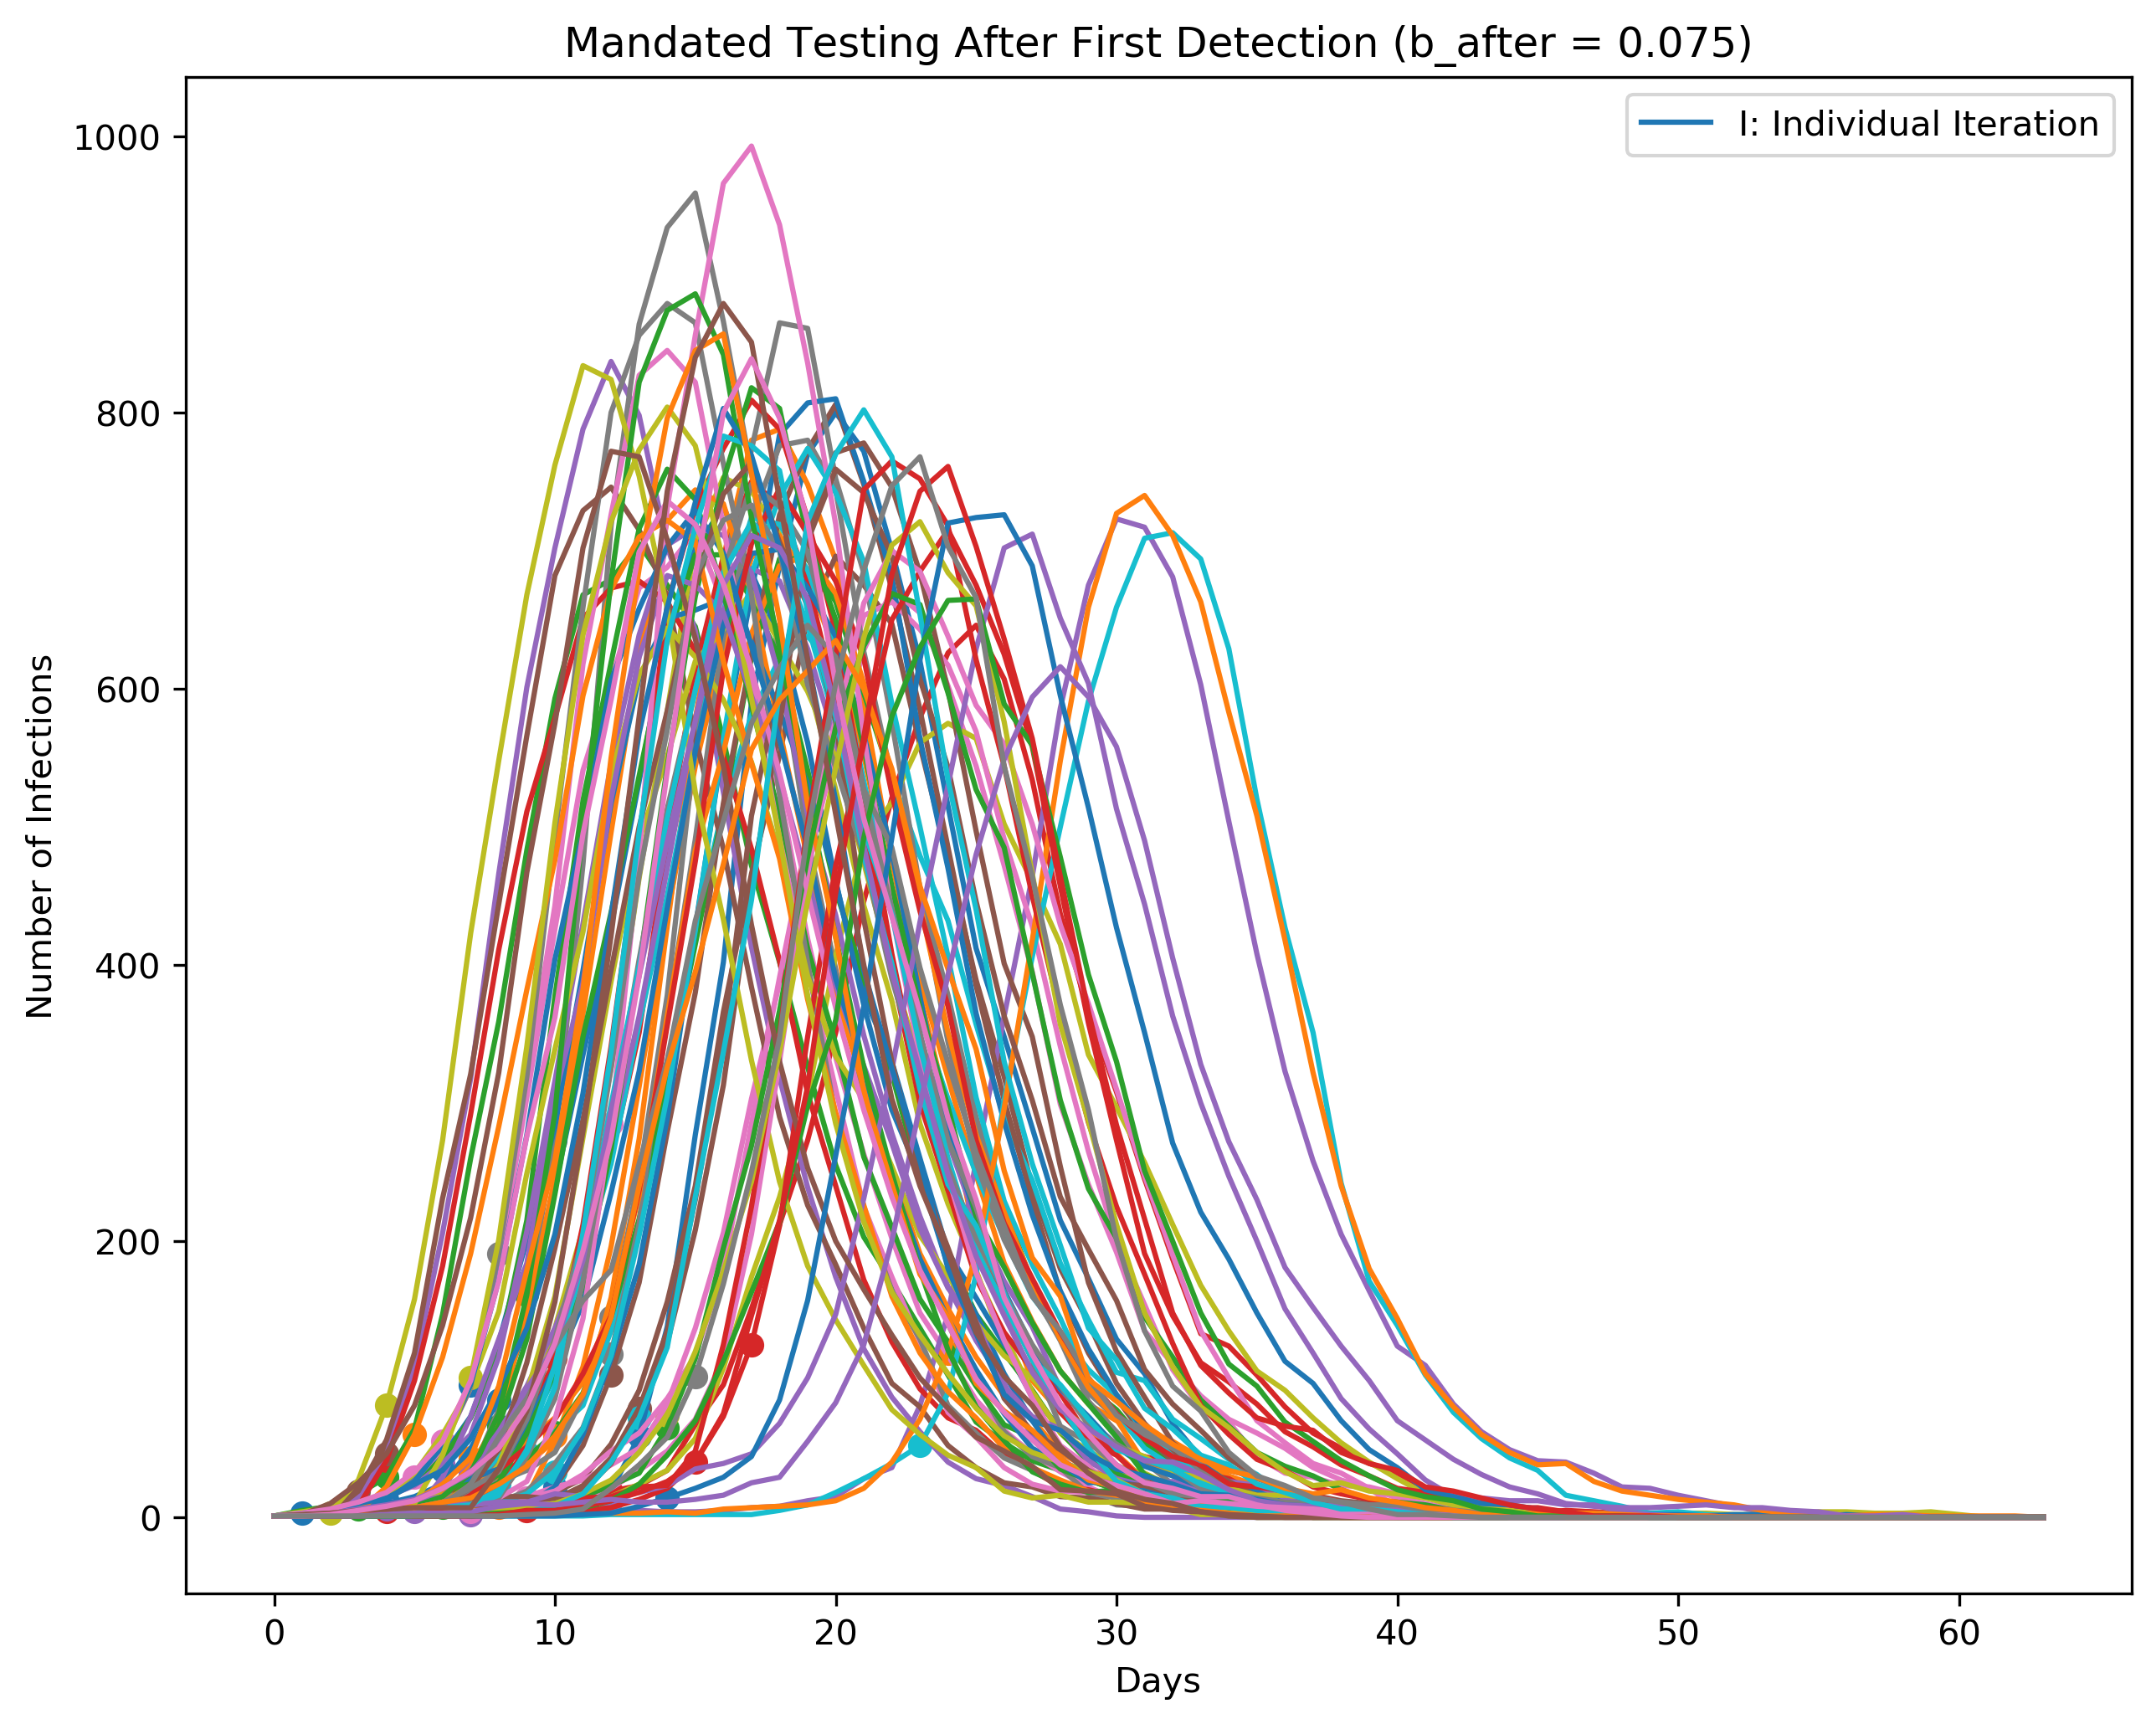

In [236]:
fig,ax = plt.subplots(figsize=(10,8))
plt.title('Mandated Testing After First Detection (b_after = 0.075)')
ax.set_xlabel('Days')
ax.set_ylabel('Number of Infections')
for i in range(0,len(I_all)):
    if(detections[i]!=-1):
        ax.scatter(detections[i],I_all[i][detections[i]])
        ax.plot(np.arange(0,len(I_all[i]),1),I_all[i])
        
ax.legend(['I: Individual Iteration'])
fig.set_dpi(300)
fig.savefig('After_First0075bAllTested.png')

In [199]:
max_days = max(len(I_all[i]) for i in range(len(I_all)))
ave_d = np.average([i for i in detections if i !=-1])


In [230]:
avg_peaktime = 0
count = 0
for i in range(len(I_all)):
    if(detections[i]!=-1):
        count = count+1
        idx = np.argmax(I_all[i])
        avg_peaktime= avg_peaktime+(idx-detections[i])
        
avg_peaktime/count

9.884615384615385

In [231]:
with open('After_First0075bAllTested', 'wb') as f:
    pickle.dump(I_all, f)

In [208]:
for I in I_all:
    while(len(I)<max_days):
        I.append(0)
        
I = np.average(I_all,axis=0)

In [229]:
for i in range(0,len(I_all)):
    if(detections[i]!=-1):
        

8.576923076923077

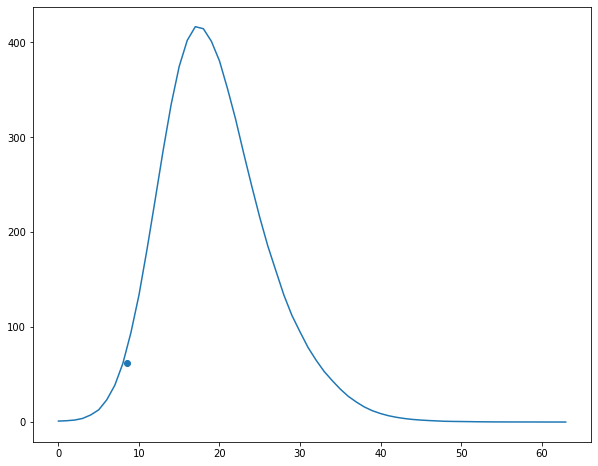

In [213]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(np.arange(0,max_days,1),I)
ax.scatter(ave_d,I[(int)(ave_d)])
# for i in range(0,len(I_all)):
#     if(detections[i]!=-1):
# #         ax.scatter(detections[i],I_all[i][detections[i]])
#         ax.plot(np.arange(0,len(I_all[i]),1),I_all[i],'--')

In [233]:
I_50_all = []
R_50_all = []
detections_50 = []
G = nx.barabasi_albert_graph(4000,3)
for i in range(100):
    s,i,r,t,d = network_iter(G,percentInc=0.5)
    I_50_all.append(i)
    R_50_all.append(r)
    detections_50.append(d)

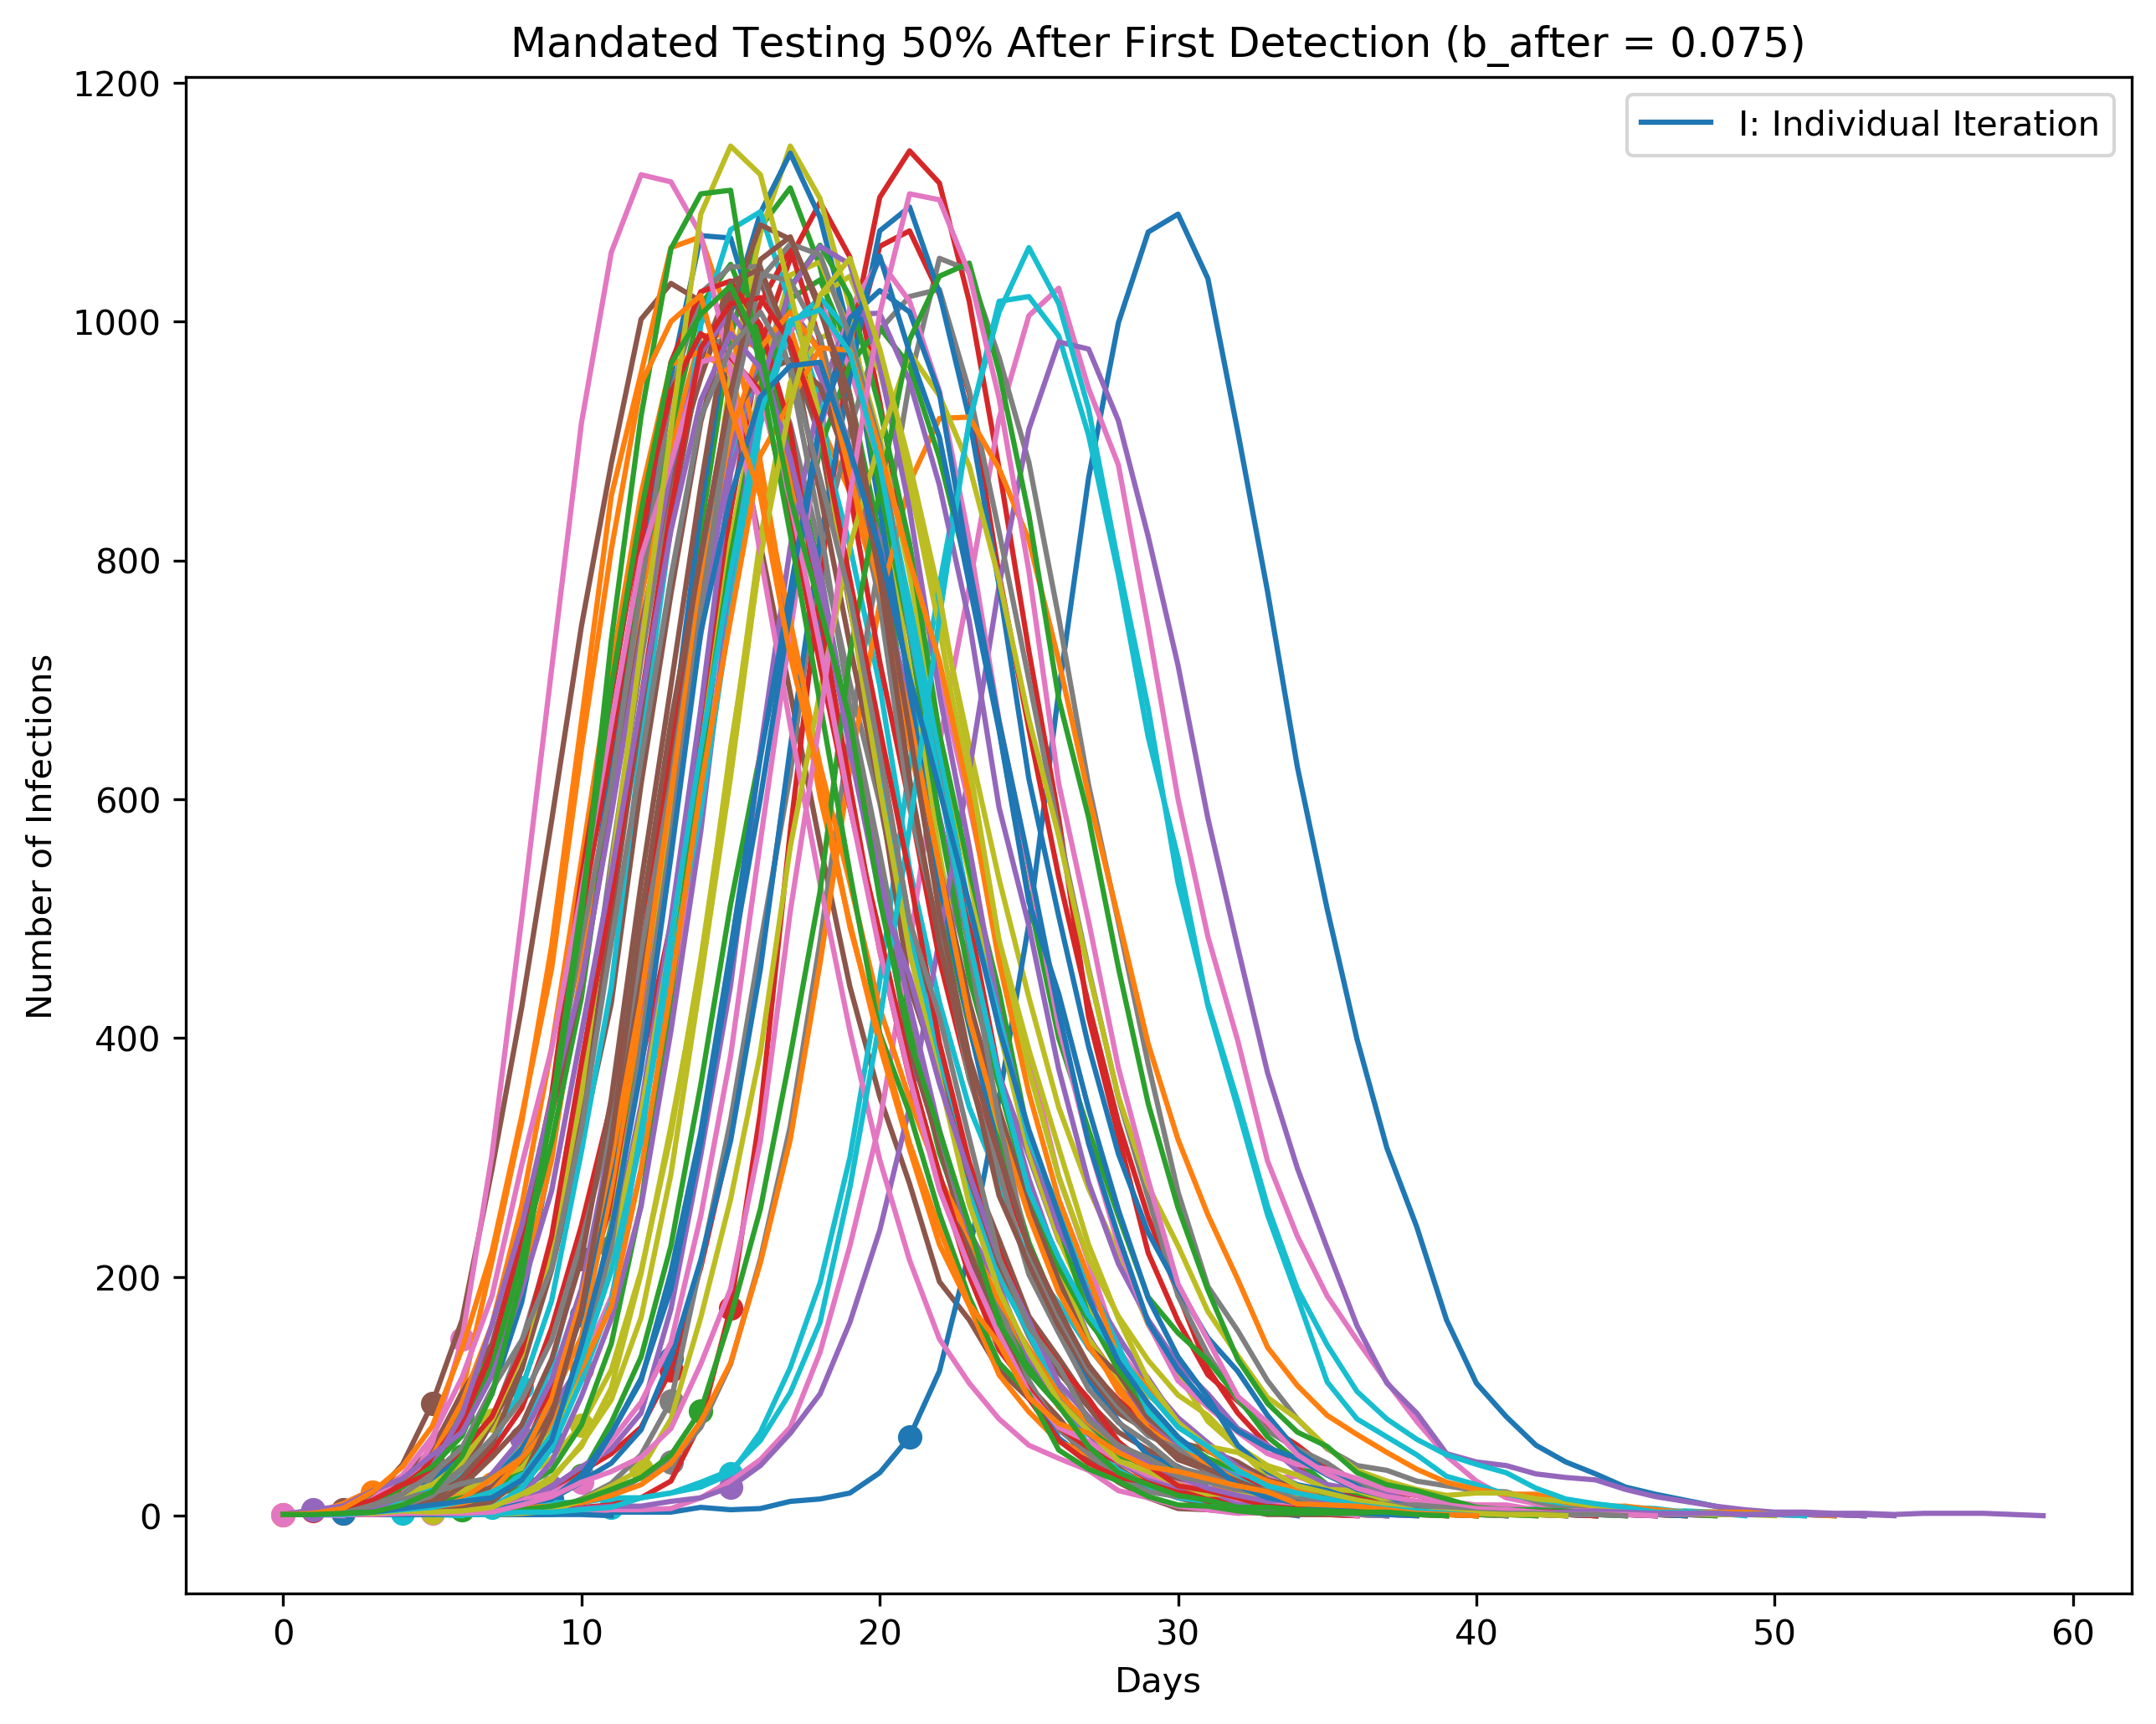

In [234]:
fig,ax = plt.subplots(figsize=(10,8))
plt.title('Mandated Testing 50% After First Detection (b_after = 0.075)')
ax.set_xlabel('Days')
ax.set_ylabel('Number of Infections')
for i in range(0,len(I_50_all)):
    if(detections_50[i]!=-1):
        ax.scatter(detections_50[i],I_50_all[i][detections_50[i]])
        ax.plot(np.arange(0,len(I_50_all[i]),1),I_50_all[i])
        
ax.legend(['I: Individual Iteration'])
fig.set_dpi(300)
fig.savefig('50After_First0075bAllTested.png')

In [235]:
avg_peaktime = 0
count = 0
for i in range(len(I_50_all)):
    if(detections_50[i]!=-1):
        count = count+1
        idx = np.argmax(I_50_all[i])
        avg_peaktime= avg_peaktime+(idx-detections_50[i])
        
avg_peaktime/count

9.95890410958904

In [237]:
with open('50After_First0075bAllTested', 'wb') as f:
    pickle.dump(I_50_all, f)